In [1]:
from meta_transformer import torch_utils, module_path, on_cluster
import os
from time import time
from dataclasses import dataclass
import torch
from meta_transformer.data import split_data
import numpy as np
import chex
from tqdm import tqdm
from meta_transformer import preprocessing
import matplotlib.pyplot as plt

/rds/user/lsl38/hpc-work/miniconda3/envs/meta-models/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load real model checkpoints

In [2]:
@dataclass
class Args:
    ndata: int = 10
    dataset: str = 'mnist'
    chunk_size: int = 256
    bs: int = 2
    augment: bool = True

args = Args()

args = Args(
    ndata=1000,
    dataset='cifar10',
)

if args.dataset == 'mnist':
    architecture = torch_utils.CNNSmall()  # for MNIST
elif args.dataset == 'cifar10':
    architecture = torch_utils.CNNMedium()  # for CIFAR-10

In [3]:
print(f'Initial memory allocated: {torch.cuda.memory_allocated() / (1024 ** 2)} MB')
print(f'Initial memory reserved: {torch.cuda.memory_reserved() / (1024 ** 2)} MB')

Initial memory allocated: 0.0 MB
Initial memory reserved: 0.0 MB


In [4]:
#%%prun -s cumtime -l 30 -T 01_loading_data.txt
if not on_cluster:
    dpath = os.path.join(module_path, "data/david_backdoors")  # local
else:
    dpath = "/rds/user/lsl38/rds-dsk-lab-eWkDxBhxBrQ/model-zoo/"  

model_dataset_paths = {
    "mnist": "mnist-cnns",
    "cifar10": "cifar10",
    "svhn": "svhn",
}

model_dataset_paths = {
    k: os.path.join(dpath, v) for k, v in model_dataset_paths.items()
}

inputs_dirnames = {
    "mnist": "poison",
    "cifar10": "poison_noL1",
#    "cifar10": "poison_easy6_alpha_50",
    "svhn": "poison_noL1",
}

inputs_dir = os.path.join(model_dataset_paths[args.dataset], inputs_dirnames[args.dataset])
targets_dir = os.path.join(model_dataset_paths[args.dataset], "clean")

print("Loading data...")
s = time()
inputs, targets, get_pytorch_model = torch_utils.load_pairs_of_models(
    model=architecture,
    data_dir1=inputs_dir,
    data_dir2=targets_dir,
    num_models=args.ndata,
    prefix2="clean",
)
print("Data loading and processing took", round(time() - s), "seconds.")

Loading data...
Loading pairs of models from:
/rds/user/lsl38/rds-dsk-lab-eWkDxBhxBrQ/model-zoo/cifar10/poison_noL1
/rds/user/lsl38/rds-dsk-lab-eWkDxBhxBrQ/model-zoo/cifar10/clean
Data loading and processing took 1 seconds.


In [5]:
print("loaded", len(inputs), "models")

loaded 99 models


In [6]:
print(f'Current memory allocated: {torch.cuda.memory_allocated() / (1024 ** 2)} MB')
print(f'Current memory reserved: {torch.cuda.memory_reserved() / (1024 ** 2)} MB')

Current memory allocated: 0.0 MB
Current memory reserved: 0.0 MB


In [7]:
import jax
data_arr = jax.flatten_util.ravel_pytree(inputs)

In [8]:
def flatten(params):
    return jax.flatten_util.ravel_pytree(params)[0]


@jax.jit
def get_mean_and_std(params):
    p = flatten(params)
    return p.mean(), p.std()

In [9]:
stats = [get_mean_and_std(p) for p in inputs]
means, stds = [np.array(x) for x in zip(*stats)]
print(means.std())
print(means.mean())
print(means.max())
print(means.min())

0.00014969872
5.4342592e-05
0.00044967612
-0.00031329828


In [10]:
stats = [get_mean_and_std(p) for p in targets]
tar_means, tar_stds = [np.array(x) for x in zip(*stats)]
print(tar_means.std())
print(tar_means.mean())
print(tar_means.max())
print(tar_means.min())

0.00019914206
-0.00024082969
0.00033919257
-0.0006595357


(array([ 2., 15., 13., 14., 18., 23.,  7.,  4.,  1.,  2.]),
 array([-6.59535697e-04, -5.59662876e-04, -4.59790055e-04, -3.59917205e-04,
        -2.60044384e-04, -1.60171563e-04, -6.02987348e-05,  3.95740899e-05,
         1.39446915e-04,  2.39319750e-04,  3.39192571e-04]),
 <BarContainer object of 10 artists>)

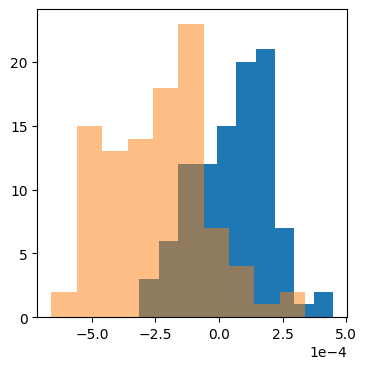

In [11]:
plt.figure(figsize=(4,4))
plt.locator_params(nbins=5)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.hist(means)
plt.hist(tar_means, alpha=0.5)

#plt.xscale("log")

(array([ 2.,  3.,  3.,  5., 17., 12., 18., 22., 14.,  3.]),
 array([0.08149739, 0.08902769, 0.09655798, 0.10408828, 0.11161858,
        0.11914888, 0.12667918, 0.13420948, 0.14173977, 0.14927007,
        0.15680037]),
 <BarContainer object of 10 artists>)

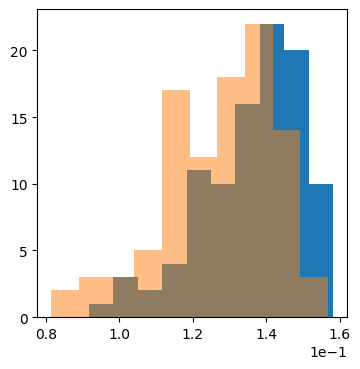

In [12]:
plt.figure(figsize=(4,4))
plt.locator_params(nbins=5)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.hist(stds)
plt.hist(tar_stds, alpha=0.5)

#plt.xscale("log")